In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from torch.optim import AdamW


In [2]:
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(1)

### Technical and Macro signals.

In [3]:
df = pd.read_csv("data_final.csv")
df = df.sort_values("observation_date")
df = df.reset_index(drop=True)

macro_features = [
    'FEDFUNDS',       # Federal Funds Rate
    'UNRATE',         # Unemployment Rate
    'GS10',           # 10-Year Treasury Yield
    'DTWEXBGS',       # Dollar Index
    'DCOILWTICO',     # Oil Prices
    'GOLD',           # Gold Prices
    'MOVE',           # MOVE Index
    'VIXCLS'          # Volatility Index (VIX)
]

technical_features = [
    'SMA_10',         # 10-day Simple Moving Average
    'SMA_50',         # 50-day Simple Moving Average
    'EMA_10',         # 10-day Exponential Moving Average
    'EMA_50',         # 50-day Exponential Moving Average
    'ROC_10',         # 10-day Rate of Change
    'RSI_14',         # 14-day Relative Strength Index
    'BB_upper',       # Upper Bollinger Band
    'BB_lower',       # Lower Bollinger Band
    'Volatility_20'   # 20-day Rolling Volatility
]

df['log_return'] = np.log(df['SP500'] / df['SP500'].shift(1))
df = df.dropna().reset_index(drop=True)

target = 'log_return'

X_macro = df[macro_features].values
y_macro = df[[target]].values
X_technical = df[technical_features].values
y_technical = df[[target]].values


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch 1/200 | Train: 4.3410 | Val: 0.4828 | Test: 0.5651
Epoch 2/200 | Train: 2.4723 | Val: 0.1749 | Test: 0.2322
Epoch 3/200 | Train: 1.0182 | Val: 0.0328 | Test: 0.0547
Epoch 4/200 | Train: 0.2649 | Val: 0.0177 | Test: 0.0034
Epoch 5/200 | Train: 0.1548 | Val: 0.0517 | Test: 0.0126
Epoch 6/200 | Train: 0.1851 | Val: 0.0737 | Test: 0.0262
Epoch 7/200 | Train: 0.2415 | Val: 0.0657 | Test: 0.0234
Epoch 8/200 | Train: 0.1540 | Val: 0.0440 | Test: 0.0127
Epoch 9/200 | Train: 0.0904 | Val: 0.0259 | Test: 0.0050
Epoch 10/200 | Train: 0.0876 | Val: 0.0166 | Test: 0.0027
Epoch 11/200 | Train: 0.0860 | Val: 0.0131 | Test: 0.0026
Epoch 12/200 | Train: 0.1008 | Val: 0.0124 | Test: 0.0026
Epoch 13/200 | Train: 0.0870 | Val: 0.0131 | Test: 0.0025
Epoch 14/200 | Train: 0.0735 | Val: 0.0148 | Test: 0.0030
Epoch 15/200 | Train: 0.0719 | Val: 0.0165 | Test: 0.0039
Epoch 16/200 | Train: 0.0755 | Val: 0.0175 | Test: 0.0048
Epoch 17/200 | Train: 0.0757 | Val: 0.0169 | Test: 0.0049
Epoch 18/200 | Train: 0

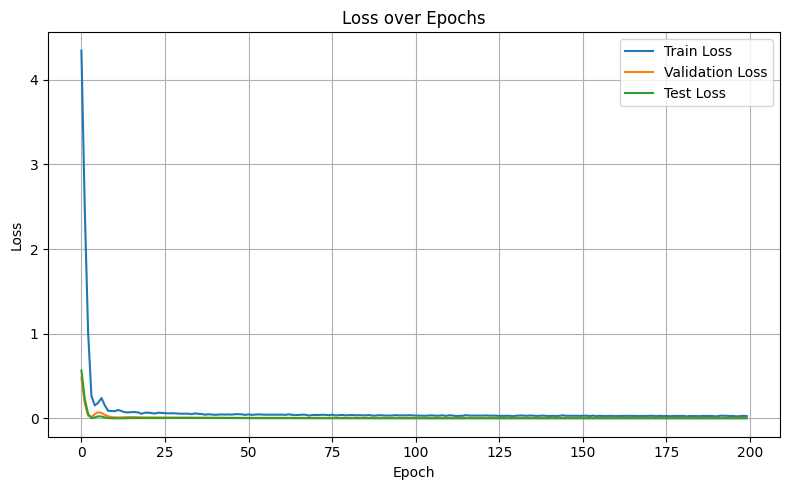

In [ ]:
def create_sequences(X, y, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length])
    return np.array(X_seq), np.array(y_seq)

seq_length = 20
X_macro_seq_raw, y_macro_seq_raw = create_sequences(X_macro, y_macro, seq_length)

def train_val_test_split(X, y, train_ratio=0.7, val_ratio=0.15):
    total = X.shape[0]
    train_end = int(total * train_ratio)
    val_end = int(total * (train_ratio + val_ratio))
    return X[:train_end], y[:train_end], X[train_end:val_end], y[train_end:val_end], X[val_end:], y[val_end:]

X_train_raw, y_train_raw, X_val_raw, y_val_raw, X_test_raw, y_test_raw = train_val_test_split(X_macro_seq_raw, y_macro_seq_raw)

macro_scaler = MinMaxScaler()
X_train_flat = X_train_raw.reshape(-1, X_train_raw.shape[-1])
X_train_scaled = macro_scaler.fit_transform(X_train_flat).reshape(X_train_raw.shape)
X_val_scaled = macro_scaler.transform(X_val_raw.reshape(-1, X_val_raw.shape[-1])).reshape(X_val_raw.shape)
X_test_scaled = macro_scaler.transform(X_test_raw.reshape(-1, X_test_raw.shape[-1])).reshape(X_test_raw.shape)

y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train_raw)
y_val_scaled = y_scaler.transform(y_val_raw)
y_test_scaled = y_scaler.transform(y_test_raw)

X_train = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train = torch.tensor(y_train_scaled, dtype=torch.float32)
X_val = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val = torch.tensor(y_val_scaled, dtype=torch.float32)
X_test = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test = torch.tensor(y_test_scaled, dtype=torch.float32)

class SP500Transformer(nn.Module):
    def __init__(self, input_dim, seq_length, d_model=64, nhead=4, num_layers=2, dim_feedforward=128):
        super(SP500Transformer, self).__init__()
        self.input_proj = nn.Linear(input_dim, d_model)

        def get_sinusoidal_encoding(seq_len, d_model):
            position = torch.arange(seq_len).unsqueeze(1)
            div_term = torch.exp(torch.arange(0, d_model, 2) * (-np.log(10000.0) / d_model))
            pe = torch.zeros(seq_len, d_model)
            pe[:, 0::2] = torch.sin(position * div_term)
            pe[:, 1::2] = torch.cos(position * div_term)
            return pe

        self.register_buffer('pos_encoding', get_sinusoidal_encoding(seq_length, d_model))

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dropout=0.1,
            dim_feedforward=dim_feedforward,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.output_layer = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.input_proj(x) + self.pos_encoding
        x = self.encoder(x)
        x = x[:, -1, :]
        return self.output_layer(x)

batch_size = 64
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=False)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SP500Transformer(input_dim=X_train.shape[2], seq_length=X_train.shape[1]).to(device)

criterion = nn.HuberLoss()
optimizer = AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)

def train_model(model, train_loader, val_loader, test_loader, epochs=200):
    train_losses, val_losses, test_losses = [], [], []

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            loss = criterion(model(X_batch), y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        val_loss = sum(criterion(model(Xb.to(device)), yb.to(device)).item()
                       for Xb, yb in val_loader)
        test_loss = sum(criterion(model(Xb.to(device)), yb.to(device)).item()
                        for Xb, yb in test_loader)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        test_losses.append(test_loss)

        print(f"Epoch {epoch+1}/{epochs} | Train: {train_loss:.4f} | Val: {val_loss:.4f} | Test: {test_loss:.4f}")

    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

train_model(model, train_loader, val_loader, test_loader)
torch.save(model, "sp500_transformer_macro.pth")

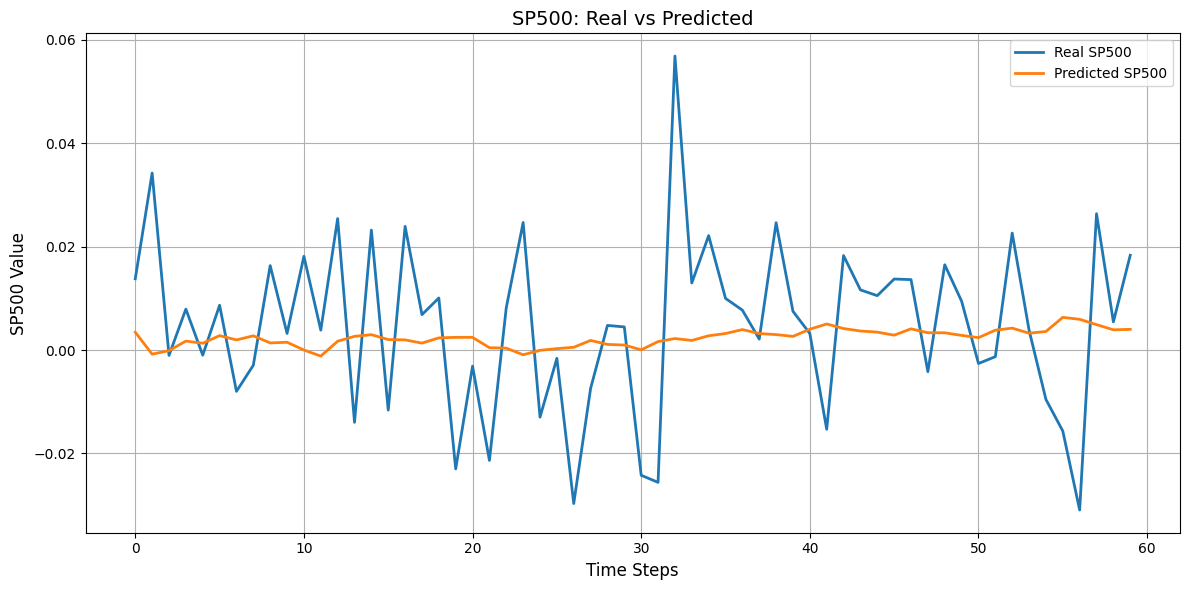

In [ ]:
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=64, shuffle=False)
model.eval()

with torch.no_grad():
    X_test_device = X_test.to(next(model.parameters()).device)
    preds = model(X_test_device).cpu().numpy()  

y_test_np = y_test.cpu().numpy() 
sp500_real = y_scaler.inverse_transform(y_test_np)
sp500_pred = y_scaler.inverse_transform(preds)

plt.figure(figsize=(12, 6))
plt.plot(sp500_real, label='Real SP500', linewidth=2)
plt.plot(sp500_pred, label='Predicted SP500', linewidth=2)
plt.title('SP500: Real vs Predicted', fontsize=14)
plt.xlabel('Time Steps', fontsize=12)
plt.ylabel('SP500 Value', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [6]:
real = sp500_real.flatten()
pred = sp500_pred.flatten()
real_diff = np.sign(np.diff(real))
pred_diff = np.sign(np.diff(pred))
directional_accuracy = np.mean(real_diff == pred_diff)

print(f"Directional Accuracy: {directional_accuracy:.2%}")

Directional Accuracy: 54.24%


Epoch 1/200 | Train: 1.2027 | Val: 0.1226 | Test: 0.1793
Epoch 2/200 | Train: 0.3625 | Val: 0.0215 | Test: 0.0444
Epoch 3/200 | Train: 0.0710 | Val: 0.0078 | Test: 0.0040
Epoch 4/200 | Train: 0.0842 | Val: 0.0217 | Test: 0.0042
Epoch 5/200 | Train: 0.1385 | Val: 0.0220 | Test: 0.0044
Epoch 6/200 | Train: 0.1151 | Val: 0.0121 | Test: 0.0022
Epoch 7/200 | Train: 0.0763 | Val: 0.0064 | Test: 0.0051
Epoch 8/200 | Train: 0.0575 | Val: 0.0064 | Test: 0.0108
Epoch 9/200 | Train: 0.0617 | Val: 0.0066 | Test: 0.0117
Epoch 10/200 | Train: 0.0562 | Val: 0.0060 | Test: 0.0084
Epoch 11/200 | Train: 0.0479 | Val: 0.0062 | Test: 0.0049
Epoch 12/200 | Train: 0.0494 | Val: 0.0073 | Test: 0.0030
Epoch 13/200 | Train: 0.0415 | Val: 0.0080 | Test: 0.0025
Epoch 14/200 | Train: 0.0497 | Val: 0.0077 | Test: 0.0026
Epoch 15/200 | Train: 0.0414 | Val: 0.0071 | Test: 0.0029
Epoch 16/200 | Train: 0.0399 | Val: 0.0068 | Test: 0.0032
Epoch 17/200 | Train: 0.0413 | Val: 0.0066 | Test: 0.0033
Epoch 18/200 | Train: 0

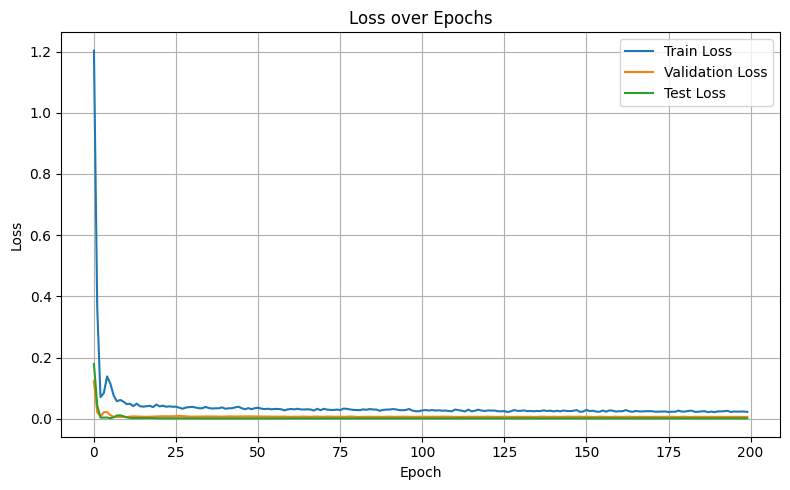

In [ ]:

X_technical = df[technical_features].values
y_technical = df[[target]].values

X_technical_seq_raw, y_technical_seq_raw = create_sequences(X_technical, y_technical, seq_length)
X_train_raw, y_train_raw, X_val_raw, y_val_raw, X_test_raw, y_test_raw = train_val_test_split(X_technical_seq_raw, y_technical_seq_raw)

tech_scaler = MinMaxScaler()
X_train_flat = X_train_raw.reshape(-1, X_train_raw.shape[-1])
X_train_scaled = tech_scaler.fit_transform(X_train_flat).reshape(X_train_raw.shape)

X_val_scaled = tech_scaler.transform(X_val_raw.reshape(-1, X_val_raw.shape[-1])).reshape(X_val_raw.shape)
X_test_scaled = tech_scaler.transform(X_test_raw.reshape(-1, X_test_raw.shape[-1])).reshape(X_test_raw.shape)

y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train_raw)
y_val_scaled = y_scaler.transform(y_val_raw)
y_test_scaled = y_scaler.transform(y_test_raw)

X_train = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train = torch.tensor(y_train_scaled, dtype=torch.float32)
X_val = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val = torch.tensor(y_val_scaled, dtype=torch.float32)
X_test = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test = torch.tensor(y_test_scaled, dtype=torch.float32)

batch_size = 64
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=False)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SP500Transformer(input_dim=X_train.shape[2], seq_length=X_train.shape[1]).to(device)

criterion = torch.nn.HuberLoss()
optimizer = AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)

def train_model(model, train_loader, val_loader, test_loader, epochs=200):
    train_losses, val_losses, test_losses = [], [], []

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        val_loss = sum(criterion(model(Xb.to(device)), yb.to(device)).item()
                       for Xb, yb in val_loader)
        test_loss = sum(criterion(model(Xb.to(device)), yb.to(device)).item()
                        for Xb, yb in test_loader)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        test_losses.append(test_loss)

        print(f"Epoch {epoch+1}/{epochs} | Train: {train_loss:.4f} | Val: {val_loss:.4f} | Test: {test_loss:.4f}")

    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

train_model(model, train_loader, val_loader, test_loader)
torch.save(model, "sp500_transformer_technical.pth")


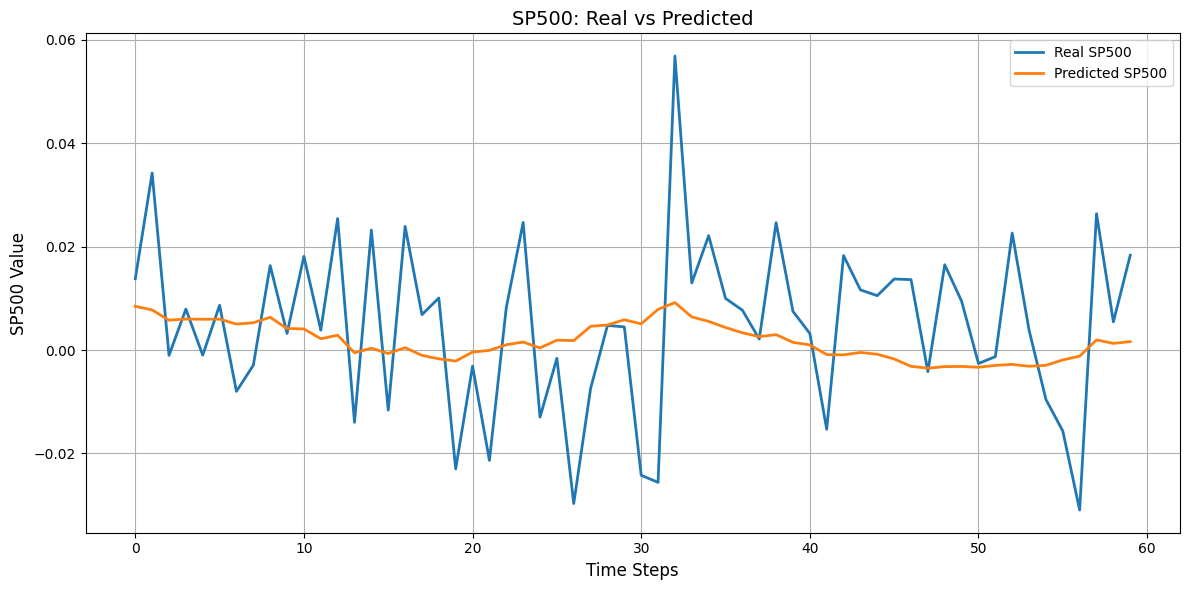

Directional Accuracy: 76.27%


In [8]:
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=64, shuffle=False)
model.eval()

with torch.no_grad():
    X_test_device = X_test.to(next(model.parameters()).device)
    preds = model(X_test_device).cpu().numpy() 

y_test_np = y_test.cpu().numpy()  
sp500_real = y_scaler.inverse_transform(y_test_np)
sp500_pred = y_scaler.inverse_transform(preds)

plt.figure(figsize=(12, 6))
plt.plot(sp500_real, label='Real SP500', linewidth=2)
plt.plot(sp500_pred, label='Predicted SP500', linewidth=2)
plt.title('SP500: Real vs Predicted', fontsize=14)
plt.xlabel('Time Steps', fontsize=12)
plt.ylabel('SP500 Value', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

real = sp500_real.flatten()
pred = sp500_pred.flatten()
real_diff = np.sign(np.diff(real))
pred_diff = np.sign(np.diff(pred))
directional_accuracy = np.mean(real_diff == pred_diff)

print(f"Directional Accuracy: {directional_accuracy:.2%}")

Epoch 1/200 | Train: 1.4566 | Val: 0.0610 | Test: 0.0639
Epoch 2/200 | Train: 0.3764 | Val: 0.0086 | Test: 0.0026
Epoch 3/200 | Train: 0.1026 | Val: 0.0563 | Test: 0.0422
Epoch 4/200 | Train: 0.1989 | Val: 0.0702 | Test: 0.0544
Epoch 5/200 | Train: 0.1426 | Val: 0.0408 | Test: 0.0284
Epoch 6/200 | Train: 0.0797 | Val: 0.0154 | Test: 0.0073
Epoch 7/200 | Train: 0.0603 | Val: 0.0072 | Test: 0.0019
Epoch 8/200 | Train: 0.0719 | Val: 0.0063 | Test: 0.0018
Epoch 9/200 | Train: 0.0680 | Val: 0.0070 | Test: 0.0018
Epoch 10/200 | Train: 0.0652 | Val: 0.0096 | Test: 0.0032
Epoch 11/200 | Train: 0.0611 | Val: 0.0116 | Test: 0.0045
Epoch 12/200 | Train: 0.0620 | Val: 0.0115 | Test: 0.0044
Epoch 13/200 | Train: 0.0555 | Val: 0.0100 | Test: 0.0034
Epoch 14/200 | Train: 0.0507 | Val: 0.0085 | Test: 0.0025
Epoch 15/200 | Train: 0.0523 | Val: 0.0075 | Test: 0.0020
Epoch 16/200 | Train: 0.0492 | Val: 0.0076 | Test: 0.0021
Epoch 17/200 | Train: 0.0620 | Val: 0.0086 | Test: 0.0025
Epoch 18/200 | Train: 0

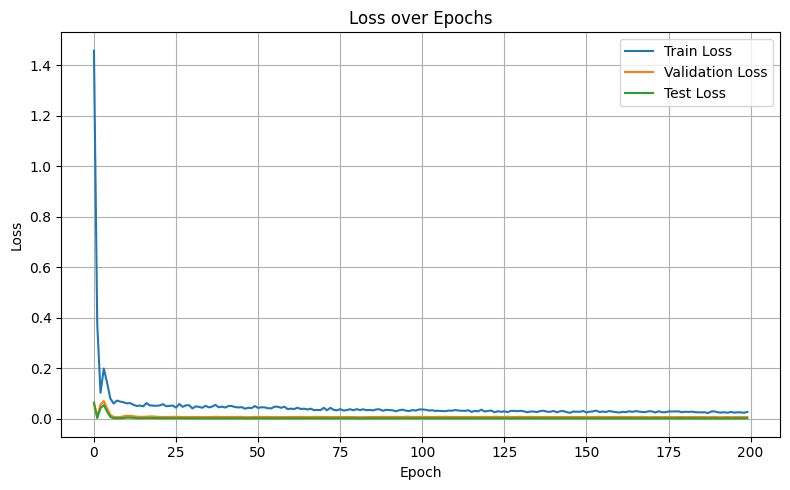

In [ ]:
features = macro_features + technical_features
X_all = df[features].values
y_all = df[[target]].values

X_all_seq_raw, y_all_seq_raw = create_sequences(X_all, y_all, seq_length)
X_train_raw, y_train_raw, X_val_raw, y_val_raw, X_test_raw, y_test_raw = train_val_test_split(X_all_seq_raw, y_all_seq_raw)

scaler_all = MinMaxScaler()
X_train_flat = X_train_raw.reshape(-1, X_train_raw.shape[-1])
X_train_scaled = scaler_all.fit_transform(X_train_flat).reshape(X_train_raw.shape)

X_val_scaled = scaler_all.transform(X_val_raw.reshape(-1, X_val_raw.shape[-1])).reshape(X_val_raw.shape)
X_test_scaled = scaler_all.transform(X_test_raw.reshape(-1, X_test_raw.shape[-1])).reshape(X_test_raw.shape)

y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train_raw)
y_val_scaled = y_scaler.transform(y_val_raw)
y_test_scaled = y_scaler.transform(y_test_raw)

X_train = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train = torch.tensor(y_train_scaled, dtype=torch.float32)
X_val = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val = torch.tensor(y_val_scaled, dtype=torch.float32)
X_test = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test = torch.tensor(y_test_scaled, dtype=torch.float32)

batch_size = 64
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=False)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SP500Transformer(input_dim=X_train.shape[2], seq_length=X_train.shape[1]).to(device)

criterion = torch.nn.HuberLoss()
optimizer = AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)

def train_model(model, train_loader, val_loader, test_loader, epochs=200):
    train_losses, val_losses, test_losses = [], [], []

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            loss = criterion(model(X_batch), y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        val_loss = sum(criterion(model(Xb.to(device)), yb.to(device)).item()
                       for Xb, yb in val_loader)
        test_loss = sum(criterion(model(Xb.to(device)), yb.to(device)).item()
                        for Xb, yb in test_loader)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        test_losses.append(test_loss)

        print(f"Epoch {epoch+1}/{epochs} | Train: {train_loss:.4f} | Val: {val_loss:.4f} | Test: {test_loss:.4f}")

    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

train_model(model, train_loader, val_loader, test_loader)
torch.save(model, "sp500_transformer_full.pth")


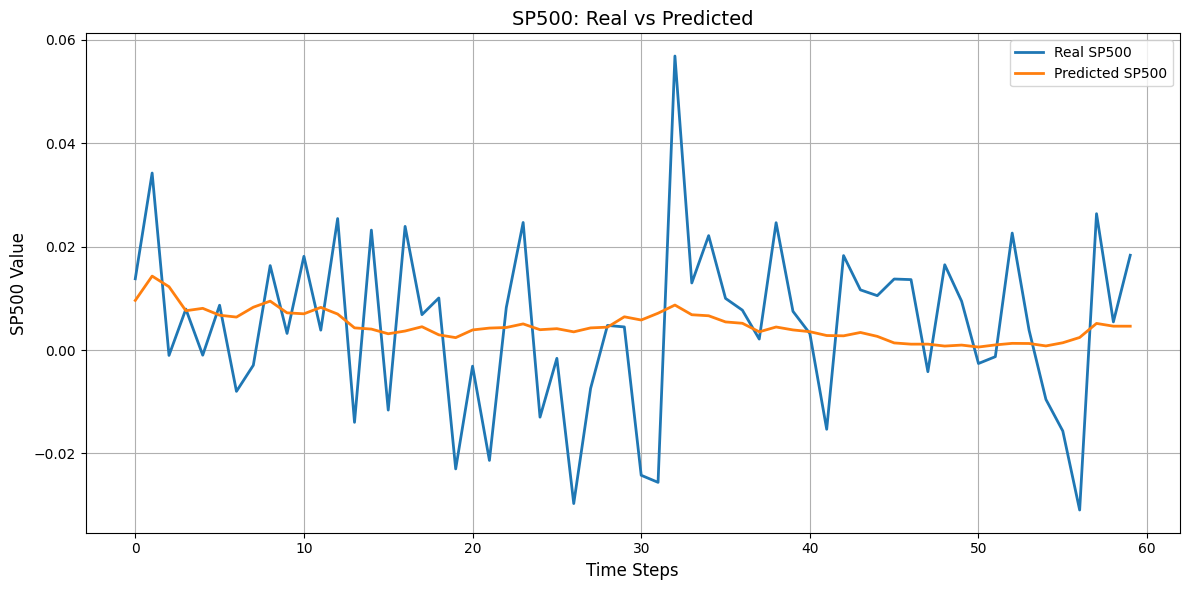

Directional Accuracy: 62.71%


In [10]:
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=64, shuffle=False)
model.eval()

with torch.no_grad():
    X_test_device = X_test.to(next(model.parameters()).device)
    preds = model(X_test_device).cpu().numpy() 

y_test_np = y_test.cpu().numpy() 
sp500_real = y_scaler.inverse_transform(y_test_np)
sp500_pred = y_scaler.inverse_transform(preds)

plt.figure(figsize=(12, 6))
plt.plot(sp500_real, label='Real SP500', linewidth=2)
plt.plot(sp500_pred, label='Predicted SP500', linewidth=2)
plt.title('SP500: Real vs Predicted', fontsize=14)
plt.xlabel('Time Steps', fontsize=12)
plt.ylabel('SP500 Value', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

real = sp500_real.flatten()
pred = sp500_pred.flatten()
real_diff = np.sign(np.diff(real))
pred_diff = np.sign(np.diff(pred))

directional_accuracy = np.mean(real_diff == pred_diff)
print(f"Directional Accuracy: {directional_accuracy:.2%}")